<a href="https://colab.research.google.com/github/aminhm00/Texture_segmentation/blob/main/Co_Occurrence_Matrix_Kmeans_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

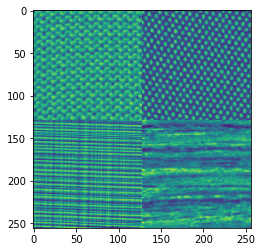

In [3]:
imageRGB1= cv2.imread("4TEXT.TIF")
imageGRAY1 = cv2.cvtColor(imageRGB1,cv2.COLOR_BGR2GRAY)
plt.imshow(imageGRAY1)

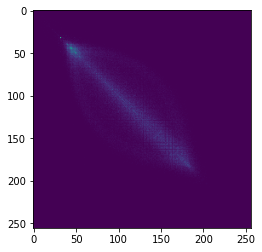

In [8]:
from skimage.feature import greycomatrix, greycoprops
from multiprocessing import Pool

glcm = greycomatrix(imageGRAY1, [1], [0], 256, symmetric=True, normed=False)
cm = glcm.reshape(256,256).astype(np.uint8)
plt.imshow(cm)

In [10]:
from scipy import stats

mean = int(cm.mean())

im_g_border2 = cv2.copyMakeBorder(cm, top=10 , bottom=10 , left=10 , right=10, borderType=cv2.BORDER_CONSTANT,value=mean)
l , c = im_g_border.shape


descriptor = np.zeros((256,256,5))
for i in range(10,l-10):
    for j in range(10,c-10):
        glcm = greycomatrix(imageGRAY1[i-10:i+10,j-10:j+10], [1], [0], 256, symmetric=True, normed=False)
        dissimilarity = greycoprops(glcm, 'dissimilarity')[0,0] 
        contrast =  greycoprops(glcm, 'contrast')[0,0] 
        homogeneity = greycoprops(glcm, 'homogeneity')[0,0] 
        energy = greycoprops(glcm, 'energy')[0,0] 
        correlation = greycoprops(glcm, 'correlation')[0,0] 
        descriptor[i-10,j-10] = [dissimilarity,contrast,homogeneity,energy,correlation]
descriptor.shape

(256, 256, 5)

In [13]:
vectorized_descriptors = descriptor.reshape(-1,5)
vectorized_descriptors.shape

(65536, 5)

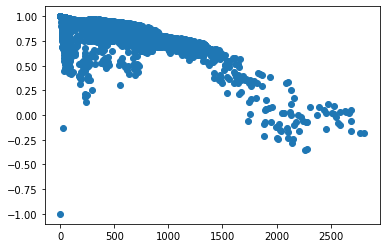

In [14]:
plt.scatter(vectorized_descriptors[:,1],vectorized_descriptors[:,4])

In [22]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 5 , init='k-means++', max_iter=100, n_init=10, random_state=0)
clusters_pred = model.fit_predict(vectorized_descriptors)

<h1>Segmentation using Kmeans</h1>

In [23]:
cluster_df = pd.concat([pd.DataFrame(imageGRAY1.flatten(),columns=['gray']),
                             pd.DataFrame(clusters_pred, columns=['cluster'])], axis=1)

cluster_df.loc[cluster_df.cluster == 0 ,"gray"]=0
cluster_df.loc[cluster_df.cluster == 1 ,"gray"]=70
cluster_df.loc[cluster_df.cluster == 2 ,"gray"]=140
cluster_df.loc[cluster_df.cluster == 3 ,"gray"]=255



final_texture = cluster_df[cluster_df.columns[:-1]].values
final_texture

array([[  0],
       [  0],
       [  0],
       ...,
       [140],
       [140],
       [140]], dtype=uint8)

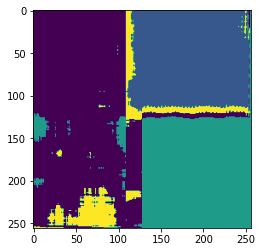

In [24]:
final_texture = final_texture.reshape(imageGRAY1.shape)
plt.imshow(final_texture)

<h1>Segmentation using GMM</h1>

In [25]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5)#,covariance_type='full'
clusters_pred2 = gmm.fit_predict(vectorized_descriptors)

In [20]:
cluster_df2 = pd.concat([pd.DataFrame(imageGRAY1.flatten(),columns=['gray']),
                             pd.DataFrame(clusters_pred2, columns=['cluster'])], axis=1)

cluster_df2.loc[cluster_df2.cluster == 0 ,"gray"]=0
cluster_df2.loc[cluster_df2.cluster == 1 ,"gray"]=70
cluster_df2.loc[cluster_df2.cluster == 2 ,"gray"]=140
cluster_df2.loc[cluster_df2.cluster == 3 ,"gray"]=255



final_texture2 = cluster_df2[cluster_df2.columns[:-1]].values
final_texture2.shape

(65536, 1)

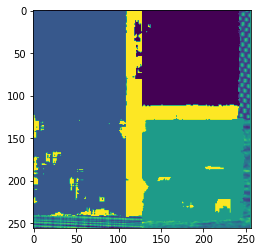

In [26]:
final_texture2 = final_texture2.reshape(imageGRAY1.shape)
plt.imshow(final_texture2)

<h1>CO-Occurrence matrix descriptor and histogram features combination with ACP</h1>

In [28]:
from scipy import stats

mean = int(imageGRAY1.mean())
im_g_border = cv2.copyMakeBorder(imageGRAY1, top=10 , bottom=10 , left=10 , right=10, borderType=cv2.BORDER_CONSTANT, value=mean)
im_g_border.shape

l , c = im_g_border.shape
descriptor2 = np.zeros((256,256,4))
for i in range(10,l-10):
    for j in range(10,c-10):
        m =  int(imageGRAY1[i-10:i+10,j-10:j+10].flatten().mean())
        e =  int(imageGRAY1[i-10:i+10,j-10:j+10].flatten().std())
        skewness = stats.skew(imageGRAY1[i-10:i+10,j-10:j+10].flatten())
        entropy = stats.entropy(imageGRAY1[i-10:i+10,j-10:j+10].flatten())
        descriptor2[i-10,j-10] = [m,e,skewness,entropy]
descriptor2.shape

(256, 256, 4)

In [29]:
comb = np.dstack((descriptor,descriptor2))
comb.shape

(256, 256, 9)

In [31]:
vectorized_descriptors2 = comb.reshape(-1,9)
vectorized_descriptors2.shape

(65536, 9)

In [32]:
from sklearn.preprocessing import StandardScaler
#PCA is effected by scale so we need to scale features
descript = pd.DataFrame(data=vectorized_descriptors2 , columns= ['dissimilarity', 'contrast', 'homogeneity', 'energy','correlation',"mean","ecart","swekness","entropy"])

X = StandardScaler().fit_transform(vectorized_descriptors2)
X_frame = pd.DataFrame(data=X , columns= ['dissimilarity', 'contrast', 'homogeneity', 'energy','correlation',"mean","ecart","swekness","entropy"])
X_frame.head()

,dissimilarity,contrast,homogeneity,energy,correlation,mean,ecart,swekness,entropy
0,-0.085763,-0.297391,-0.792900,-0.207830,0.035601,0.857283,-0.286202,-1.483764,0.357044
1,-0.000193,-0.229549,-0.863002,-0.210238,-0.098627,0.857283,-0.408909,-1.621223,0.361005
2,0.008672,-0.221016,-0.857633,-0.200619,-0.100057,0.976767,-0.408909,-1.749878,0.362270
3,-0.082679,-0.308994,-0.675205,-0.186263,0.076626,0.976767,-0.286202,-1.727206,0.358525
4,-0.051073,-0.286211,-0.642151,-0.160160,0.075710,0.917025,-0.286202,-1.555200,0.355127


In [33]:
from sklearn.decomposition import PCA
pca = PCA(.90)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
principalDf

,0,1,2,3
0,-0.772220,-1.052977,1.385363,0.127732
1,-0.703492,-1.078346,1.544050,0.278635
2,-0.777594,-1.133126,1.669320,0.271923
3,-0.949537,-1.102813,1.502134,0.093984
4,-0.860068,-1.022397,1.383514,0.112991
...,...,...,...,...
65531,-2.557869,18.761564,6.010308,0.074231
65532,-0.548443,20.948068,8.141356,0.691580
65533,1.459711,25.547981,10.554307,3.281601
65534,3.292034,34.708974,15.575865,6.428144


In [34]:
pca.explained_variance_ratio_

array([0.48158697, 0.21698844, 0.14758623, 0.0898931 ])

In [35]:
principalDf.values.shape

(65536, 4)

In [37]:
model = KMeans(n_clusters = 5, init='k-means++', max_iter=200, n_init=10, random_state=0)
clusters_pred_reduction = model.fit_predict(principalDf.values)


In [38]:
cluster_df3 = pd.concat([pd.DataFrame(imageGRAY1.flatten(),columns=['gray']),
                             pd.DataFrame(clusters_pred_reduction, columns=['cluster'])], axis=1)

cluster_df3.loc[cluster_df3.cluster == 0 ,"gray"]=0
cluster_df3.loc[cluster_df3.cluster == 1 ,"gray"]=70
cluster_df3.loc[cluster_df3.cluster == 2 ,"gray"]=110
cluster_df3.loc[cluster_df3.cluster == 3 ,"gray"]=190
cluster_df3.loc[cluster_df3.cluster == 4 ,"gray"]=255

final_texture_reduction = cluster_df3[cluster_df3.columns[:-1]].values


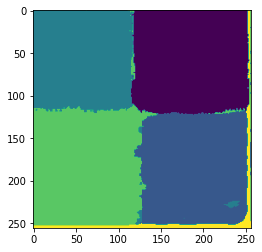

In [39]:
final_texture_reduction = final_texture_reduction.reshape(imageGRAY1.shape)
plt.imshow(final_texture_reduction)

<h1>DONE !</h1>